# **Bài toán định tuyến**

Ý tưởng: Chia bài toán làm hai giai đoạn


1.   Sử dụng K-Means để phân cụm dữ liệu
2.   Định tuyến phương tiện trong mỗi cụm

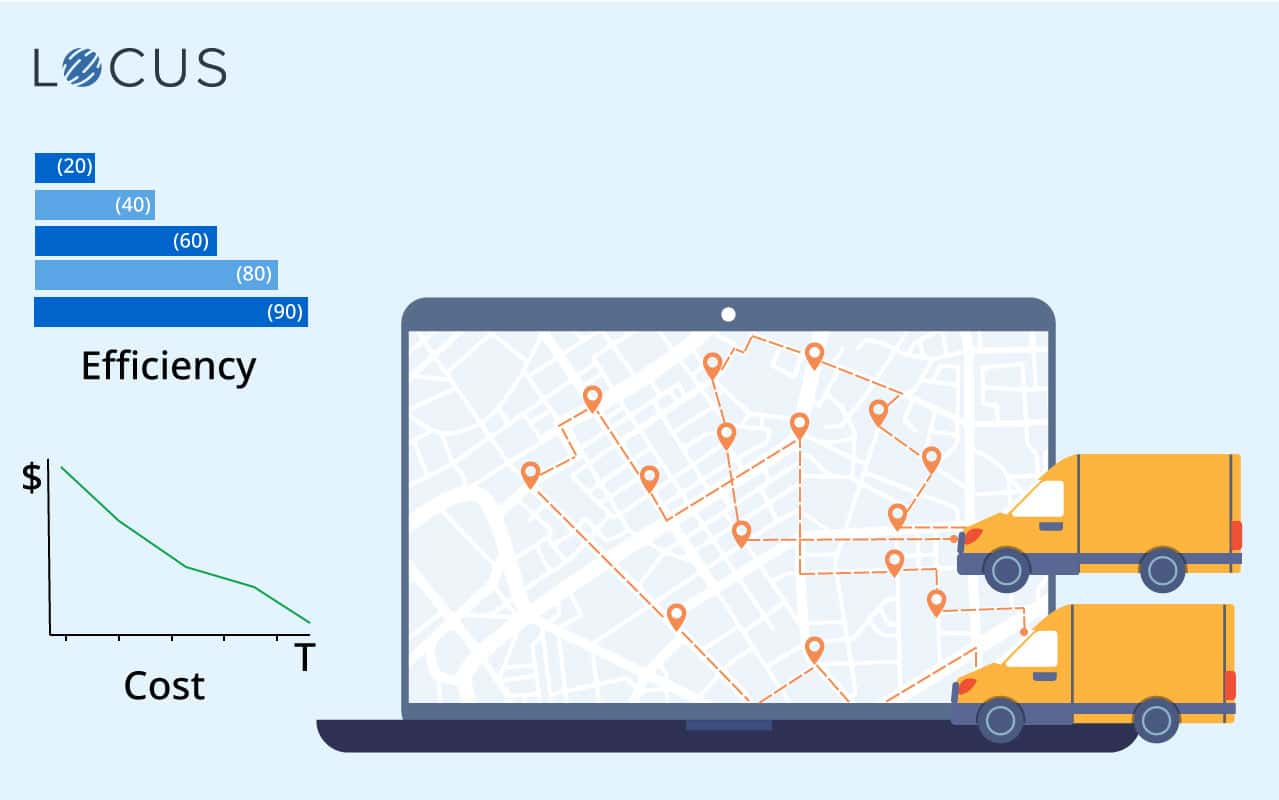



# **1. Thuật toán K-Means**



In [70]:
! pip install shapely

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
from sklearn.cluster import KMeans
from shapely.geometry import LineString, Point
from sklearn.preprocessing import StandardScaler


In [72]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [73]:
# tính priority.
def Caculate_priority(coordinates, cluster_centers_, demands):
  priority = []
  min_distance = float('inf')
  idx_D=[[] for i in range(len(coordinates))]
  for i in range(len(coordinates)):
    D=[]
    for j in range(len(cluster_centers_)):
        distance1 = distance.euclidean(coordinates[i],cluster_centers_[j])
        D.append(distance1)
    idx_D[i]=np.argsort(D)
    p = D[idx_D[i][0]]/demands[i]
    priority.append(p)
  p_idx = np.argsort(np.array(priority))
  return p_idx, idx_D,


In [74]:
# Gán vào các cụm
def Assigned(p_idx, idx_D,cluster_centers_,demands, vehicle_capacity, coordinates):
  labels = [-1 for i in range(len(coordinates))]
  capacity_recent =  [[0] for i in range(len(cluster_centers_))]
  for i in p_idx:
    for c in idx_D[i]:
      if demands[i]+capacity_recent[c][0]< vehicle_capacity:
            capacity_recent[c][0]+=demands[i]
            labels[i] = c
            break
    if labels[i]==-1:
      labels[i]=len(cluster_centers_)
  return labels, capacity_recent


In [75]:
# tính lại tâm cụm
def Caculated_centroids(labels, coordinates, k_cluster, demands):
    df_concat = pd.concat([pd.DataFrame(labels, columns = ["Labels"]),pd.DataFrame(coordinates, columns = ["X_coord","Y_coord"]), pd.DataFrame(demands, columns = ['Demands'])], axis =1)
    center = [[0,0] for i in range(k_cluster)]
    for i in range(k_cluster):
        D = 0
        for j in range(len(coordinates)):
            if i==df_concat.Labels[j]:
                center[i][0] = center[i][0]+df_concat.X_coord[j]
                center[i][1] = center[i][1]+df_concat.Y_coord[j]
                D+=1
        center[i][0] =  center[i][0]/D
        center[i][1] =  center[i][1]/D
    return center, df_concat


In [76]:
def K_means_improved(coordinates, demands, vehicle_capacity):
    k_cluster =  int(np.ceil(np.sum(demands)/vehicle_capacity))
    demands_sorted = np.argsort(-np.array(demands))
    intial_center = [coordinates[i] for i in demands_sorted[:k_cluster]]
    labels = [-1 for i in range(len(coordinates))]
    converged = False
    while not converged:
        labels_pre = list(labels)
        p_idx, idx_D = Caculate_priority(coordinates, intial_center, demands)
        labels, capacity_recent = Assigned(p_idx, idx_D, intial_center, demands, vehicle_capacity, coordinates)
        intial_center, df_concat = Caculated_centroids(labels, coordinates, k_cluster, demands)
        converged = (labels_pre == labels)
    return intial_center, df_concat, capacity_recent





# **2. Thuật toán tìm đường đi**



In [77]:
# hàm tạo ma trận trọng số
def Matrix(cluster):
    matrix = np.zeros((len(cluster), len(cluster)))
    for i in range(len(cluster)):
        for j in range(len(cluster))[i+1:]:
            dis = distance.euclidean(cluster.iloc[i][1:3], cluster.iloc[j][1:3])
            matrix[i][j]=dis
            matrix[j][i]=dis
    return matrix

In [78]:
# theem kho vao moix cumj
def Insert(new_row, label, df_concat):
  Cluster = df_concat[df_concat.Labels ==label]
  Cluster = pd.concat([pd.DataFrame([new_row]),Cluster], ignore_index=True )
  return Cluster

In [79]:
# hàm tìm đường đi ngắn nhất xuất phát từ kho
def tsp_nearest_neighbor_with_matrix(distance_matrix, start_node):
    n = len(distance_matrix)
    path = [start_node]
    visited = set(path)
    total_distance = 0
    current_node = start_node

    while len(visited) < n:
        next_node = min((node for node in range(n) if node not in visited),
                        key=lambda node: distance_matrix[current_node][node])
        total_distance += distance_matrix[current_node][next_node]
        current_node = next_node
        path.append(current_node)
        visited.add(current_node)

    total_distance += distance_matrix[current_node][start_node]
    path.append(start_node)
    return total_distance, path



In [80]:
# Visualize đường đi
def Routing_visualization(path, cluster, color, ax):
  radius = 1  # Bán kính của các hình tròn
  points = [list(cluster.iloc[i][1:3]) for i in path[:-1] ]


# Vẽ các điểm với màu viền
  for index, (x, y) in enumerate(points):
      circle = plt.Circle((x, y), radius,edgecolor=color, facecolor='white', linewidth=2, zorder=2)
      ax.add_patch(circle)
      ax.text(x, y, str(index), fontsize=12, ha='center', va='center', color='black', zorder=3)  # Thêm số thứ tự vào giữa hình tròn

# Nối các điểm với các đường nối không xuyên qua viền tròn
  for i in range(len(points)-1):
      start = points[i]
      end = points[i+1]

      line = LineString([start, end])
      start_circle = Point(start).buffer(radius)
      end_circle = Point(end).buffer(radius)

    # Tìm điểm giao nhau giữa đường và viền tròn
      start_intersect = line.intersection(start_circle.boundary)
      end_intersect = line.intersection(end_circle.boundary)

      if not start_intersect.is_empty and not end_intersect.is_empty:
          if start_intersect.geom_type == 'MultiPoint':
              start_point = start_intersect[0]
          else:
              start_point = start_intersect

          if end_intersect.geom_type == 'MultiPoint':
              end_point = end_intersect[0]
          else:
              end_point = end_intersect

          x_values = [start_point.x, end_point.x]
          y_values = [start_point.y, end_point.y]
          ax.plot(x_values, y_values, 'k-', zorder=1)  # Vẽ đường nối màu đen

  plt.gca().set_aspect('equal', adjustable='box')




# **3. Chạy thực nghiệm trên 3 bộ dữ liệu**

# 3.1. Làm sạch dữ liệu, tích hợp dữ liệu

In [81]:
# load dữ liệu
df1 = pd.read_excel("/content/drive/MyDrive/Nhóm_13_PTDLL/E-n51-k5.xlsx")
df2 = pd.read_excel("/content/drive/MyDrive/E-n101-k8.xlsx")
df3 = pd.read_excel("/content/drive/MyDrive/E-n22-k4.xlsx")

In [82]:
# lấy ra vị trí khách hàng ngoại trừ vị trí đầu tiên là kho
def get_coordinates(df, k1):
  coordinates1 = [df.loc[i][0].split(" ")[1:] for i in range(6,6+k1)]
  for i in range(len(coordinates1)):
    coordinates1[i][0]=int(coordinates1[i][0])
    coordinates1[i][1]=int(coordinates1[i][1])
# lấy ra yêu cầu khách hàng với yêu cầu đầu tiên là 0 tương ứng với kho
  demands1 = [df.loc[i][0].split(" ")[1:] for i in range(7+k1,2*k1+7)]
  for i in range(len(demands1)):
    demands1[i]=int(demands1[i][0])
  data = pd.concat([pd.DataFrame(coordinates1, columns = ["X_Coord", "Y_Coord"]),pd.DataFrame({"Demands":demands1})], axis = 1)
  return data
data1 = get_coordinates(df1, 51)
data2 = get_coordinates(df2, 101)
data3 = get_coordinates(df3, 22)

In [83]:
data1

,X_Coord,Y_Coord,Demands
0,30,40,0
1,37,52,7
2,49,49,30
3,52,64,16
4,20,26,9
5,40,30,21
6,21,47,15
7,17,63,19
8,31,62,23
9,52,33,11


In [84]:
data1.info()
print("\n")
data2.info()
print("\n")
data3.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   X_Coord  51 non-null     int64
 1   Y_Coord  51 non-null     int64
 2   Demands  51 non-null     int64
dtypes: int64(3)
memory usage: 1.3 KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   X_Coord  101 non-null    int64
 1   Y_Coord  101 non-null    int64
 2   Demands  101 non-null    int64
dtypes: int64(3)
memory usage: 2.5 KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   X_Coord  22 non-null     int64
 1   Y_Coord  22 non-null     int64
 2   Demands  22 non-null     int64
dtypes: int64(3)
memory usage: 656.0 bytes


In [85]:
duplicate_rows1 = data1[data1.duplicated()]
duplicate_rows1
duplicate_rows2 = data2[data2.duplicated()]
duplicate_rows2
duplicate_rows3 = data3[data3.duplicated()]
duplicate_rows3


,X_Coord,Y_Coord,Demands


<ipython-input-86-4a942acd258b>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  boxplot.set_xticklabels(boxplot.get_xticklabels(), fontsize=12)
<ipython-input-86-4a942acd258b>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  boxplot.set_yticklabels(boxplot.get_yticklabels(), fontsize=12)


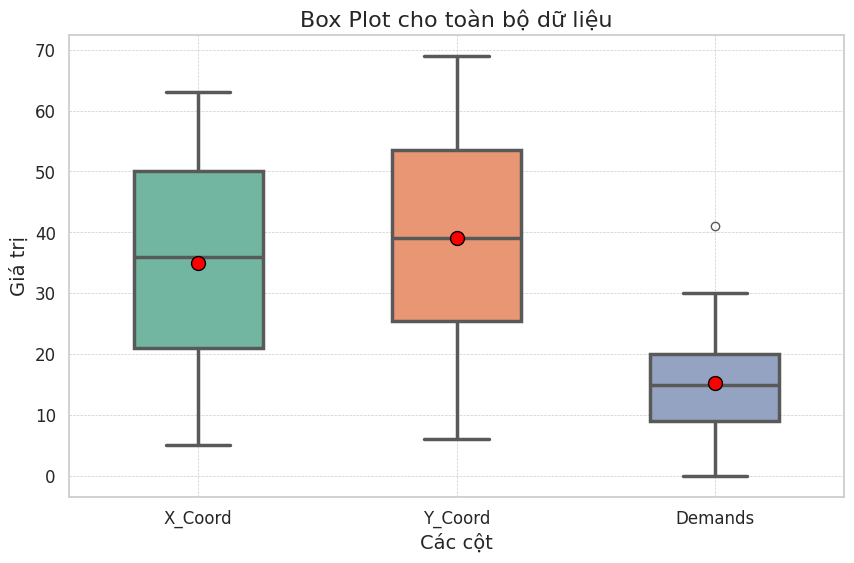

<ipython-input-86-4a942acd258b>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  boxplot.set_xticklabels(boxplot.get_xticklabels(), fontsize=12)
<ipython-input-86-4a942acd258b>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  boxplot.set_yticklabels(boxplot.get_yticklabels(), fontsize=12)


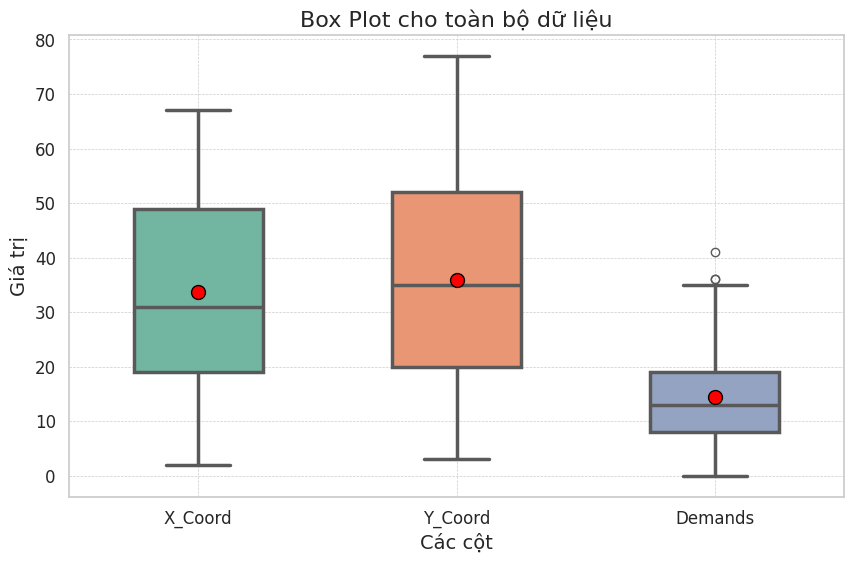

<ipython-input-86-4a942acd258b>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  boxplot.set_xticklabels(boxplot.get_xticklabels(), fontsize=12)
<ipython-input-86-4a942acd258b>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  boxplot.set_yticklabels(boxplot.get_yticklabels(), fontsize=12)


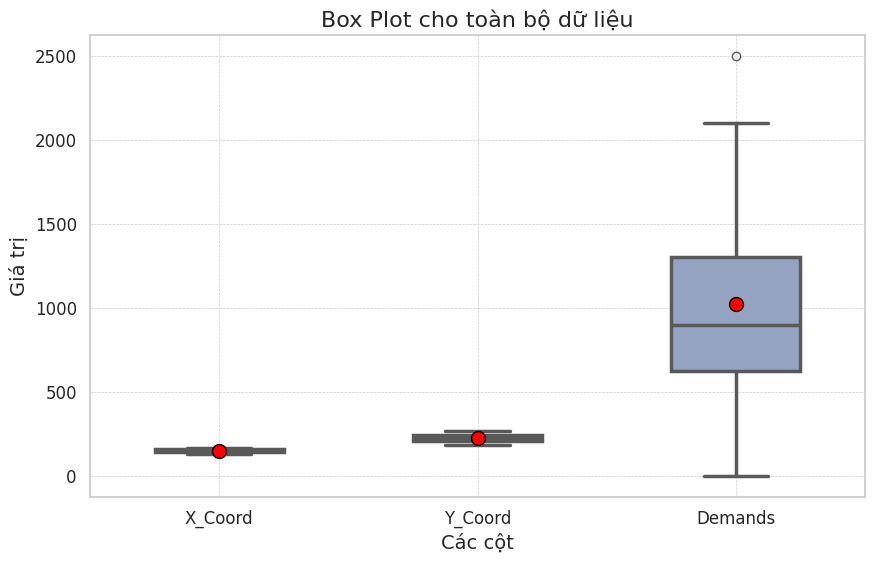

In [86]:
def box_plot(data):
  sns.set(style="whitegrid")

# Tạo figure và axes
  plt.figure(figsize=(10, 6))

# Vẽ Box plot với các tùy chỉnh
  boxplot = sns.boxplot(data=data, palette="Set2", width=0.5, linewidth=2.5, showmeans=True,
                      meanprops={"marker":"o", "markerfacecolor":"red", "markeredgecolor":"black", "markersize":"10"})

# Thêm tiêu đề và nhãn trục
  plt.title('Box Plot cho toàn bộ dữ liệu', fontsize=16)
  plt.xlabel('Các cột', fontsize=14)
  plt.ylabel('Giá trị', fontsize=14)

# Tăng kích thước của các nhãn trục
  boxplot.set_xticklabels(boxplot.get_xticklabels(), fontsize=12)
  boxplot.set_yticklabels(boxplot.get_yticklabels(), fontsize=12)

# Thêm gridlines
  plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Hiển thị biểu đồ
  plt.show()
box_plot(data1)
box_plot(data2)
box_plot(data3)

# 3.2. Lựa chọn dữ liệu

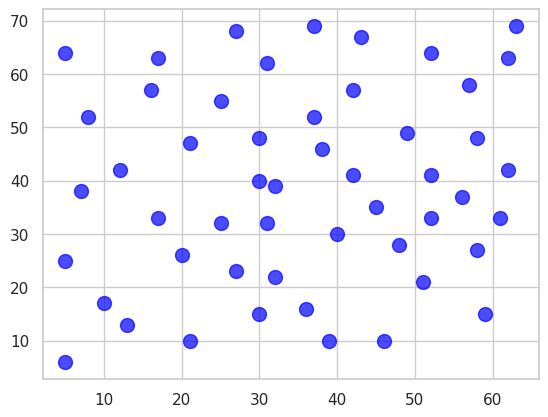

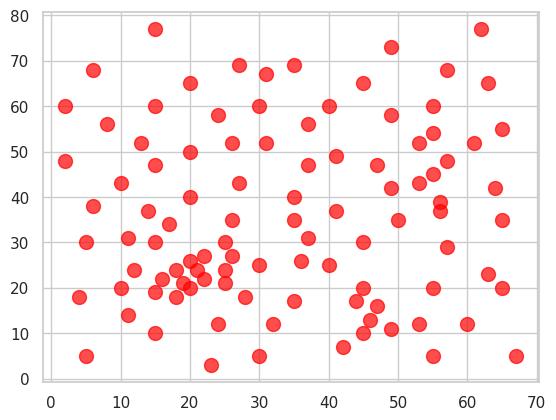

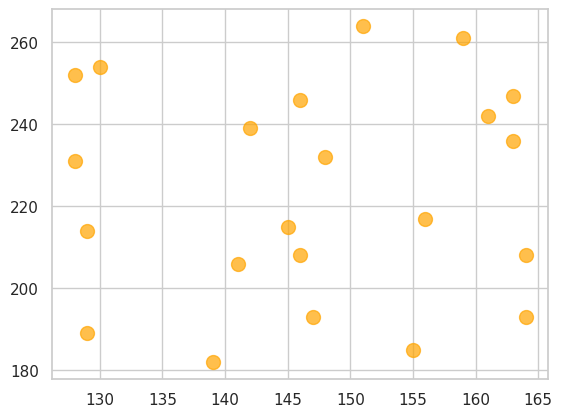

In [87]:
# Vị trí khach hàng
plt.scatter( data1.X_Coord ,data1.Y_Coord, c='blue', s=100, alpha=0.7)
plt.show()
plt.scatter( data2.X_Coord ,data2.Y_Coord, c='red', s=100, alpha=0.7)
plt.show()
plt.scatter( data3.X_Coord ,data3.Y_Coord, c='orange', s=100, alpha=0.7)
plt.show()

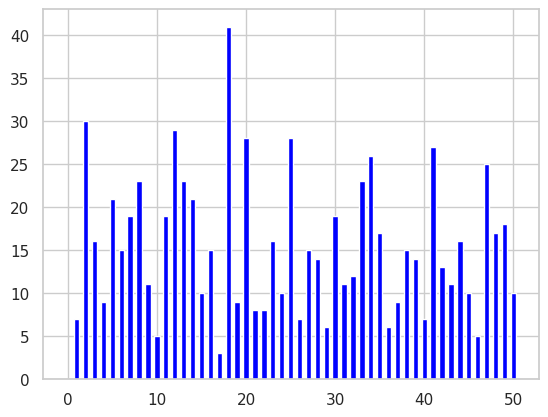

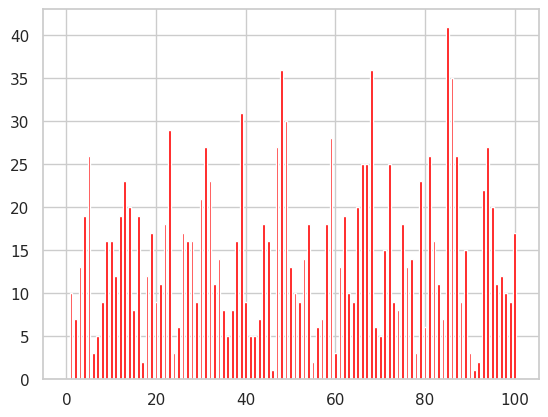

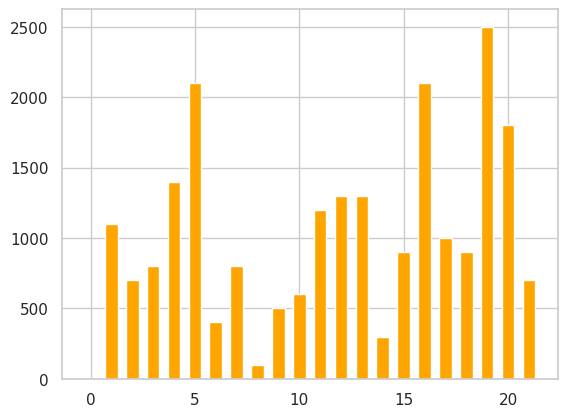

In [88]:
# Nhu cầu khách hàng
plt.bar(range(len(data1.Demands)),data1.Demands, width=0.6, color=['blue'])
plt.show()
plt.bar(range(len(data2.Demands)),data2.Demands, width=0.6, color=['red'])
plt.show()
plt.bar(range(len(data3.Demands)),data3.Demands, width=0.6, color=['orange'])
plt.show()

In [89]:
data1.Demands.describe()
print("\n")
data2.Demands.describe()
print("\n")
data3.Demands.describe()

count      22.000000
mean     1022.727273
std       656.057357
min         0.000000
25%       625.000000
50%       900.000000
75%      1300.000000
max      2500.000000
Name: Demands, dtype: float64

# 3.3 Khai phá dữ liệu

In [90]:
# dung tích xe
vehicle_capacity1 = 160
vehicle_capacity2 = 200
vehicle_capacity3 = 6000
# chạy K-means với bộ dữ liệu
Center1, df_concat1, capacited1 = K_means_improved(np.array(data1[["X_Coord", "Y_Coord"]])[1:], np.array(data1.Demands)[1:], vehicle_capacity1)
Center2, df_concat2, capacited2 = K_means_improved(np.array(data2[["X_Coord", "Y_Coord"]])[1:], np.array(data2.Demands)[1:], vehicle_capacity2)
Center3, df_concat3, capacited3 = K_means_improved(np.array(data3[["X_Coord", "Y_Coord"]])[1:], np.array(data3.Demands)[1:], vehicle_capacity3)

# Số lượn các điểm trong từng cụm
df_concat1.groupby(by = "Labels").count()


,X_coord,Y_coord,Demands
Labels,,,
0,7,7,7
1,10,10,10
2,12,12,12
3,10,10,10
4,11,11,11


In [91]:
df_concat2.groupby(by = "Labels").count()

,X_coord,Y_coord,Demands
Labels,,,
0,17,17,17
1,12,12,12
2,10,10,10
3,10,10,10
4,15,15,15
5,12,12,12
6,11,11,11
7,13,13,13


In [92]:
df_concat3.groupby(by = "Labels").count()

,X_coord,Y_coord,Demands
Labels,,,
0,6,6,6
1,4,4,4
2,6,6,6
3,5,5,5


# 3.4. Kết quả minh họa

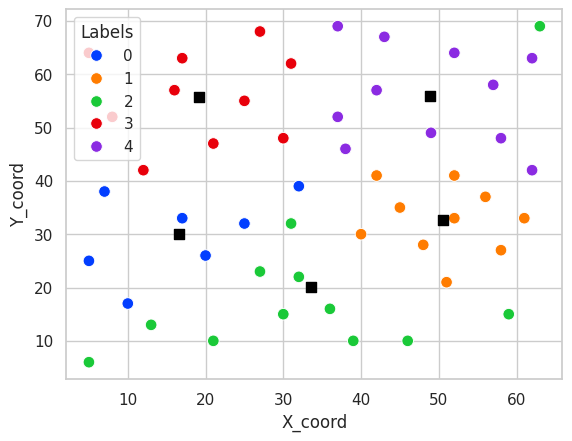

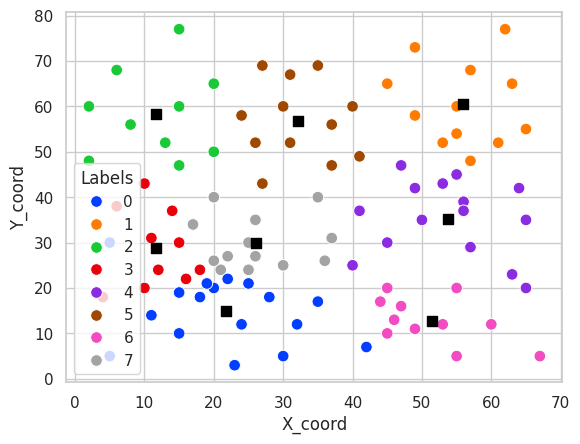

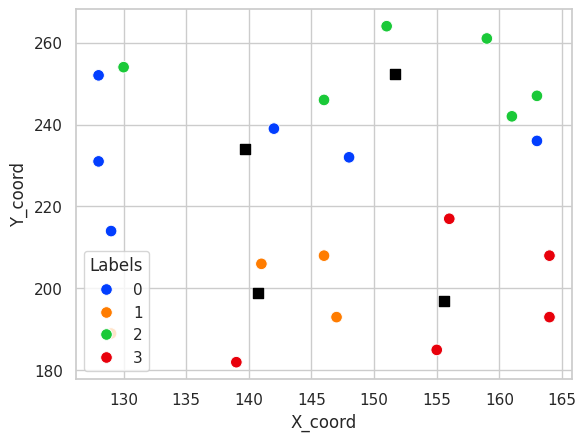

In [93]:
# Kết quả sau khi phân cụm ( hình vuông đen là tâm cụm) 1
sns.scatterplot(x='X_coord', y='Y_coord', hue=df_concat1.Labels, data=df_concat1[["X_coord", "Y_coord"]], palette="bright", s = 70)
plt.scatter([x[0] for x in Center1], [x[1] for x in Center1], marker='s', c = "black", s =50 )
plt.show()
# Kết quả sau khi phân cụm ( hình vuông đen là tâm cụm) 2
sns.scatterplot(x='X_coord', y='Y_coord', hue=df_concat2.Labels, data=df_concat2[["X_coord", "Y_coord"]], palette="bright", s = 70)
plt.scatter([x[0] for x in Center2], [x[1] for x in Center2], marker='s', c = "black", s =50 )
plt.show()
# Kết quả sau khi phân cụm ( hình vuông đen là tâm cụm) 3
sns.scatterplot(x='X_coord', y='Y_coord', hue=df_concat3.Labels, data=df_concat3[["X_coord", "Y_coord"]], palette="bright", s = 70)
plt.scatter([x[0] for x in Center3], [x[1] for x in Center3], marker='s', c = "black", s =50 )
plt.show()

In [94]:
# Thêm kho vào các cụm bộ 1
new_row1 = {'Labels': -1, 'X_coord': 30, 'Y_coord':40, 'Demands':0}
cluster10 = Insert(new_row1, 0, df_concat1)
cluster11 = Insert(new_row1, 1, df_concat1)
cluster12 = Insert(new_row1, 2, df_concat1)
cluster13 = Insert(new_row1, 3, df_concat1)
cluster14 = Insert(new_row1, 4, df_concat1)
# Thêm kho vào các cụm bộ 2
new_row2 = {'Labels': -1, 'X_coord': 35, 'Y_coord':35, 'Demands':0}
cluster20 = Insert(new_row2, 0, df_concat2)
cluster21 = Insert(new_row2, 1, df_concat2)
cluster22 = Insert(new_row2, 2, df_concat2)
cluster23 = Insert(new_row2, 3, df_concat2)
cluster24 = Insert(new_row2, 4, df_concat2)
cluster25 = Insert(new_row2, 5, df_concat2)
cluster26 = Insert(new_row2, 6, df_concat2)
cluster27 = Insert(new_row2, 7, df_concat2)
# Thêm kho vào các cụm bộ 3
new_row3 = {'Labels': -1, 'X_coord': 145, 'Y_coord':215, 'Demands':0}
cluster30 = Insert(new_row3, 0, df_concat3)
cluster31 = Insert(new_row3, 1, df_concat3)
cluster32 = Insert(new_row3, 2, df_concat3)
cluster33 = Insert(new_row3, 3, df_concat3)


In [95]:
# Tìm đường đi cho các cụm với vị trí xuất phát từ kho và kết thúc quay trở về kho
start_node = 0
total_distance, path = tsp_nearest_neighbor_with_matrix(Matrix(cluster10), start_node) # Cụm 0
print("Total distance0:", total_distance)
print("Path0:", path)
total_distance1, path1 = tsp_nearest_neighbor_with_matrix(Matrix(cluster11), start_node) # Cụm 1
print("Total distance1:", total_distance1)
print("Path1:", path1)
total_distance2, path2 = tsp_nearest_neighbor_with_matrix(Matrix(cluster12), start_node) #Cụm 2
print("Total distance2:", total_distance2)
print("Path2:", path2)
total_distance3, path3 = tsp_nearest_neighbor_with_matrix(Matrix(cluster13), start_node) #Cụm 3
print("Total distance3:", total_distance3)
print("Path3:", path3)
total_distance4, path4 = tsp_nearest_neighbor_with_matrix(Matrix(cluster14), start_node) # Cụm 4
print("Total distance4:", total_distance4)
print("Path4:", path4)
print('Sum of total distance:',total_distance+total_distance1+total_distance2+total_distance3+total_distance4)



Total distance0: 91.80835446165982
Path0: [0, 6, 7, 1, 3, 4, 2, 5, 0]
Total distance1: 108.07285779640722
Path1: [0, 4, 8, 1, 9, 2, 10, 5, 7, 6, 3, 0]
Total distance2: 219.01636441408547
Path2: [0, 1, 3, 7, 2, 11, 10, 4, 9, 12, 5, 8, 6, 0]
Total distance3: 141.25299955621705
Path3: [0, 8, 10, 1, 4, 6, 5, 2, 7, 3, 9, 0]
Total distance4: 128.7448634212854
Path4: [0, 10, 1, 6, 7, 9, 3, 4, 11, 8, 5, 2, 0]
Sum of total distance: 688.8954396496549


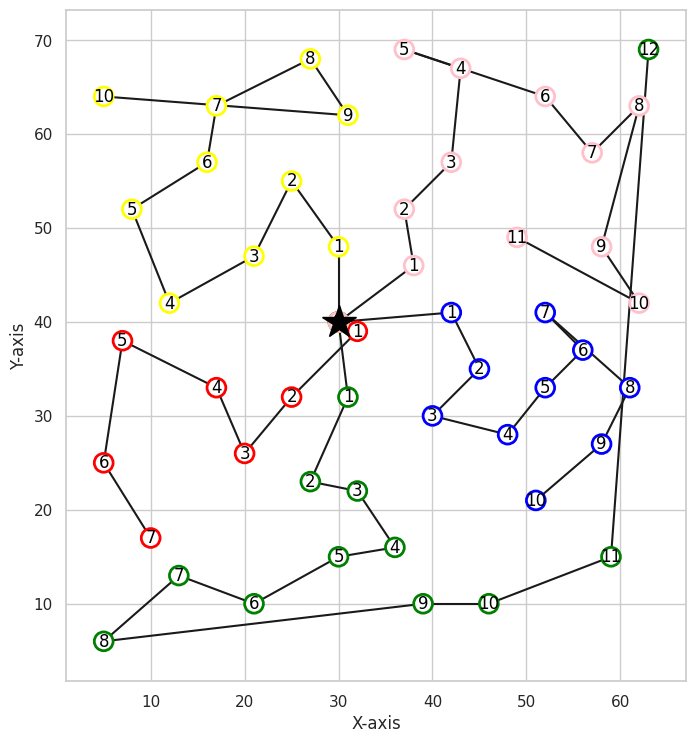

In [96]:
fig, ax = plt.subplots(figsize=(8, 20))
Routing_visualization(path, cluster10, 'red', ax)
Routing_visualization(path1, cluster11, 'blue', ax)
Routing_visualization(path2, cluster12, 'green', ax)
Routing_visualization(path3, cluster13, 'yellow', ax)
Routing_visualization(path4, cluster14, 'pink', ax)
plt.plot(30,40, c = "black", marker = "*", markersize=25)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.show()

In [97]:
start_node = 0
total_distance, path = tsp_nearest_neighbor_with_matrix(Matrix(cluster20), start_node)
print("Total distance0:", total_distance)
print("Path0:", path)
total_distance1, path1 = tsp_nearest_neighbor_with_matrix(Matrix(cluster21), start_node)
print("Total distance1:", total_distance1)
print("Path1:", path1)
total_distance2, path2 = tsp_nearest_neighbor_with_matrix(Matrix(cluster22), start_node)
print("Total distance2:", total_distance2)
print("Path2:", path2)
total_distance3, path3 = tsp_nearest_neighbor_with_matrix(Matrix(cluster23), start_node)
print("Total distance3:", total_distance3)
print("Path3:", path3)
total_distance4, path4 = tsp_nearest_neighbor_with_matrix(Matrix(cluster24), start_node)
print("Total distance4:", total_distance4)
print("Path4:", path4)
total_distance5, path5 = tsp_nearest_neighbor_with_matrix(Matrix(cluster25), start_node)
print("Total distance5:", total_distance5)
print("Path5:", path5)
total_distance6, path6 = tsp_nearest_neighbor_with_matrix(Matrix(cluster26), start_node)
print("Total distance6:", total_distance6)
print("Path6:", path6)
total_distance7, path7 = tsp_nearest_neighbor_with_matrix(Matrix(cluster27), start_node)
print("Total distance7:", total_distance7)
print("Path7:", path7)
print('Sum of total distance:',total_distance+total_distance1+total_distance2+total_distance3+total_distance4+total_distance5+total_distance6+total_distance7)

Total distance0: 202.42554065930995
Path0: [0, 15, 14, 5, 16, 17, 13, 10, 2, 8, 12, 1, 11, 3, 9, 6, 4, 7, 0]
Total distance1: 173.27325612129852
Path1: [0, 3, 12, 1, 6, 2, 8, 9, 5, 4, 10, 11, 7, 0]
Total distance2: 154.3492740926718
Path2: [0, 1, 10, 7, 6, 4, 8, 3, 2, 9, 5, 0]
Total distance3: 107.07369384670255
Path3: [0, 10, 8, 5, 3, 9, 7, 1, 6, 2, 4, 0]
Total distance4: 133.26161512891787
Path4: [0, 6, 5, 2, 15, 12, 14, 1, 13, 9, 7, 3, 10, 11, 4, 8, 0]
Total distance5: 111.76905170279456
Path5: [0, 6, 11, 4, 10, 3, 2, 7, 8, 12, 5, 1, 9, 0]
Total distance6: 110.73477624856996
Path6: [0, 2, 9, 8, 10, 3, 11, 6, 5, 4, 7, 1, 0]
Total distance7: 85.54058884278098
Path7: [0, 5, 6, 2, 10, 1, 12, 13, 7, 11, 9, 3, 8, 4, 0]
Sum of total distance: 1078.4277966430461


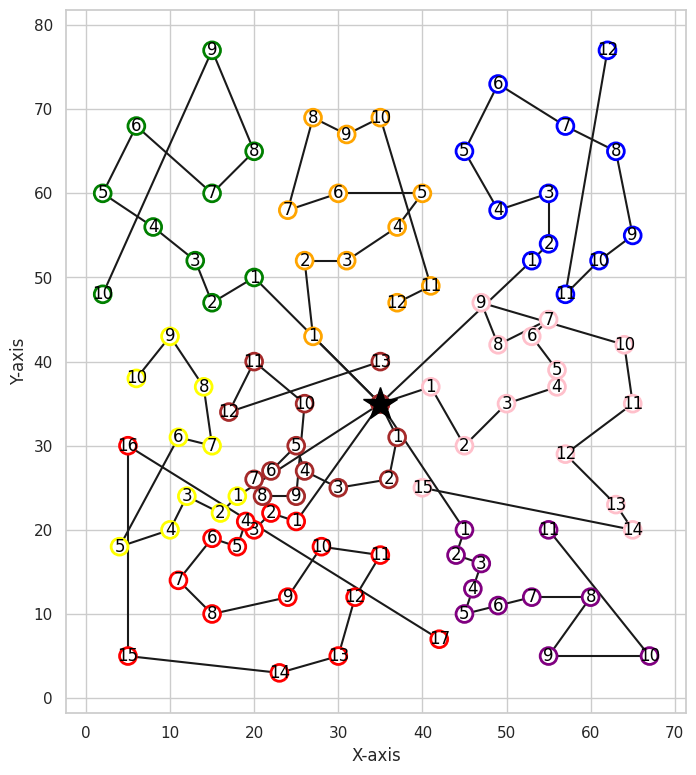

In [98]:
fig, ax = plt.subplots(figsize=(8, 20))
Routing_visualization(path, cluster20, 'red', ax)
Routing_visualization(path1, cluster21, 'blue', ax)
Routing_visualization(path2, cluster22, 'green', ax)
Routing_visualization(path3, cluster23, 'yellow', ax)
Routing_visualization(path4, cluster24, 'pink', ax)
Routing_visualization(path5, cluster25, 'orange', ax)
Routing_visualization(path6, cluster26, 'purple', ax)
Routing_visualization(path7, cluster27, 'brown', ax)
plt.plot(35,35, c = "black", marker = "*", markersize=25)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.show()

In [99]:
start_node = 0
total_distance, path = tsp_nearest_neighbor_with_matrix(Matrix(cluster30), start_node)
print("Total distance0:", total_distance)
print("Path0:", path)
total_distance1, path1 = tsp_nearest_neighbor_with_matrix(Matrix(cluster31), start_node)
print("Total distance1:", total_distance1)
print("Path:1", path1)
total_distance2, path2 = tsp_nearest_neighbor_with_matrix(Matrix(cluster32), start_node)
print("Total distance2:", total_distance2)
print("Path2:", path2)
total_distance3, path3 = tsp_nearest_neighbor_with_matrix(Matrix(cluster33), start_node)
print("Total distance3:", total_distance3)
print("Path3:", path3)
print('Sum of total distance:',total_distance+total_distance1+total_distance2+total_distance3)

Total distance0: 153.13114951075016
Path0: [0, 6, 5, 2, 4, 3, 1, 0]
Total distance1: 75.7418176418096
Path:1 [0, 1, 2, 3, 4, 0]
Total distance2: 140.0742593965931
Path2: [0, 5, 6, 4, 2, 1, 3, 0]
Total distance3: 100.08336930368009
Path3: [0, 1, 2, 3, 4, 5, 0]
Sum of total distance: 469.030595852833


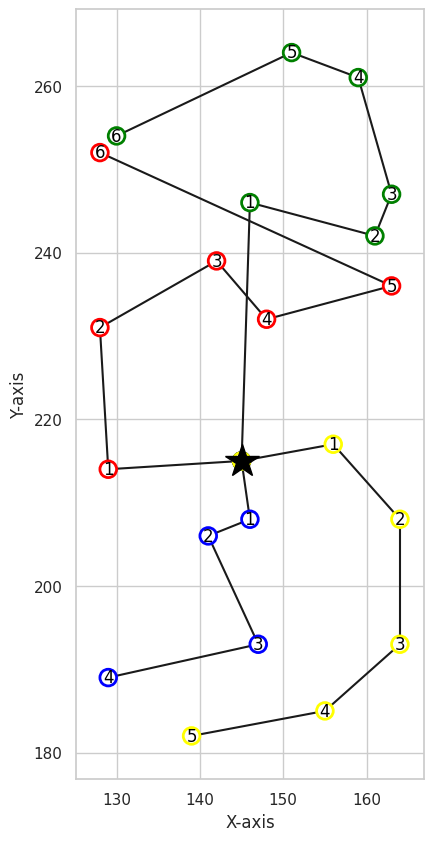

In [100]:
fig, ax = plt.subplots(figsize=(8, 10))
Routing_visualization(path, cluster30, 'red', ax)
Routing_visualization(path1, cluster31, 'blue', ax)
Routing_visualization(path2, cluster32, 'green', ax)
Routing_visualization(path3, cluster33, 'yellow', ax)
plt.plot(145,215, c = "black", marker = "*", markersize=25)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.show()

# 3.5 Đánh giá kết quả

In [101]:
# Độ phủ 1
Tighness_ratio1 = sum([x[0] for x in capacited1])/(5*vehicle_capacity1)
print("Tighness_ratio1 = ", Tighness_ratio1)
# Độ phủ 2
Tighness_ratio2 = sum([x[0] for x in capacited2])/(8*vehicle_capacity2)
print("Tighness_ratio2 = ", Tighness_ratio2)
# Độ phủ 3
Tighness_ratio3 = sum([x[0] for x in capacited3])/(4*vehicle_capacity3)
print("Tighness_ratio3 = ", Tighness_ratio3)

Tighness_ratio1 =  0.97125
Tighness_ratio2 =  0.91125
Tighness_ratio3 =  0.9375


In [102]:
# Giá trị trung bình
print("Mean1 = ",np.mean(df_concat1.Demands.groupby(by = df_concat1.Labels).mean()))
print("Mean2 = ",np.mean(df_concat2.Demands.groupby(by = df_concat2.Labels).mean()))
print("Mean3 = ",np.mean(df_concat3.Demands.groupby(by = df_concat3.Labels).mean()))

Mean1 =  16.1121645021645
Mean2 =  15.032178116001646
Mean3 =  1107.0833333333335


In [103]:
# Tính std mean
mean1 = df_concat1.Demands.groupby(by = df_concat1.Labels).mean()
print("Std1 = ",np.std(mean1))
mean2 = df_concat2.Demands.groupby(by = df_concat2.Labels).mean()
print("Std2 = ",np.std(mean2))
mean3 = df_concat3.Demands.groupby(by = df_concat3.Labels).mean()
print("Std3 = ",np.std(mean3))

Std1 =  3.4442566090178786
Std2 =  2.879617102389638
Std3 =  232.88163123498313


In [104]:
# tính sse
def calculate_sse(data, centroids, labels):
    sse = 0
    for i in range(len(data)):
        centroid = centroids[labels[i]]
        sse += np.sum((data[i] - centroid) ** 2)
    return sse
print("SSE1 = ",calculate_sse(np.array(data1[["X_Coord", "Y_Coord"]])[1:], Center1, np.array(df_concat1.Labels)))
print("SSE2 = ",calculate_sse(np.array(data2[["X_Coord", "Y_Coord"]])[1:], Center2, np.array(df_concat2.Labels)))
print("SSE3 = ",calculate_sse(np.array(data3[["X_Coord", "Y_Coord"]])[1:], Center3, np.array(df_concat3.Labels)))

SSE1 =  11290.276406926409
SSE2 =  10681.482942547644
SSE3 =  4725.949999999999
